# Study of the evolution of accuracy over the size of the dataset

The results are discussed in the report

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

from utils.shapelets_transform import *
from utils.quality_measures import *

In [23]:
def create_synthetic(N_train, N_test):
    k = 50
    motif_1 = np.concatenate((np.zeros(2), 7*np.ones(14), np.zeros(2)))
    motif_2 = np.concatenate((np.zeros(2), (np.arange(8)), (6 - np.arange(7)), np.zeros(1),))
    
    x_train = 5*np.random.randn(N_train, k)
    x_test = 5*np.random.randn(N_test, k)
    y_train = np.zeros(N_train)
    y_test = np.zeros(N_test)
    max_motif_length = max(len(motif_1), len(motif_2))

    for i in range(N_train):
        idx = np.random.randint(k-max_motif_length-1)
        if i <= N_train//2:
            x_train[i][idx:idx+len(motif_1)] += motif_1
        else:
            y_train[i] = 1
            x_train[i][idx:idx+len(motif_2)] += motif_2

    for i in range(N_test):
        idx = np.random.randint(k-max_motif_length-1)
        if i <= N_test//2:
            x_test[i][idx:idx+len(motif_1)] += motif_1
        else:
            y_test[i] = 1
            x_test[i][idx:idx+len(motif_2)] += motif_2
            
    return x_train, y_train, x_test, y_test

In [24]:
# Initialize models
models = {
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "SVM (Linear)": SVC(kernel='linear'),
    "1-NN": KNeighborsClassifier(n_neighbors=1),
    "Decision Tree": DecisionTreeClassifier(),
}

In [25]:
def train_models(x_train, y_train, x_test, y_test):
    # Train and evaluate models
    results = {}
    for name, model in models.items():
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        accuracy = accuracy_score(y_test, predictions)
        results[name] = accuracy
        
    return results

In [26]:
def shapelet_transform(x_train, y_train, x_test, y_test):
    x_shapelet = shapelet_cached_selection(x_train, y_train, 20, 30, len(x_train), compute_f_stat, verbose=1)  
    res_list = []

    for shap in x_shapelet:
        res_list.append(shap[0])
        
    transformed_x_train_shap = shapelets_transform(res_list, x_train)
    transformed_x_test_shap = shapelets_transform(res_list, x_test)
    
    clusters = cluster_shapelets(res_list, 20)
    
    list_cluster = []

    for c in clusters:
        list_cluster.append(list(c))
    
    list_cluster.sort(key=lambda x: -len(x))
    
    transformed_x_train_clust = shapelets_cluster_transform(list_cluster, x_train)
    transformed_x_test_clust = shapelets_cluster_transform(list_cluster, x_test)
    
    return transformed_x_train_shap, transformed_x_test_shap, transformed_x_train_clust, transformed_x_test_clust

In [31]:
N_test = 1000
x_N_train = [10, 20, 30, 40, 50, 80, 100, 150, 200, 400]

In [32]:
result = {}
for N_train in x_N_train:
    result[N_train] = {}
    x_train, y_train, x_test, y_test = create_synthetic(N_train, N_test)
    transformed_x_train_shap, transformed_x_test_shap, transformed_x_train_clust, transformed_x_test_clust = shapelet_transform(x_train, y_train, x_test, y_test)
    result[N_train]["Shapelet transform"] =  train_models(transformed_x_train_shap, y_train, transformed_x_test_shap, y_test)
    result[N_train]["Cluster transform"] =  train_models(transformed_x_train_clust, y_train, transformed_x_test_clust, y_test)
    result[N_train]["Raw data"] =  train_models(x_train, y_train, x_test, y_test)
    

100%|██████████| 400/400 [06:06<00:00,  1.09it/s]


In [33]:
x_shap = []
x_clust = []
x_raw = []

for N_train in x_N_train:
    x_shap.append(result[N_train]['Shapelet transform']['Naive Bayes'])
    x_clust.append(result[N_train]['Cluster transform']['Naive Bayes'])
    x_raw.append(result[N_train]['Raw data']['Naive Bayes'])

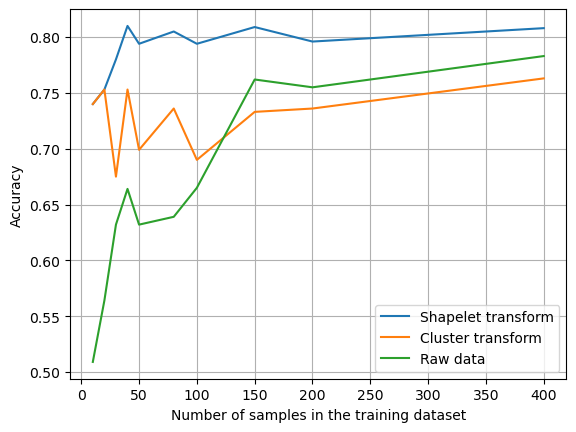

In [34]:
plt.plot(x_N_train, x_shap, label="Shapelet transform")
plt.plot(x_N_train, x_clust, label="Cluster transform")
plt.plot(x_N_train, x_raw, label="Raw data")
plt.xlabel("Number of samples in the training dataset")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)